# Top K Visualization

## 1. Libraries and Common Functions

In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import random
import kaldi_io

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from scipy import stats
from scipy.spatial.distance import pdist

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns



#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset
import torch.cuda as cutorch

#Import User defined classes
from AweNoise.models.torch_models import SimpleNet,SimpleNet_with_dropout, SiameseNet
#datsets
from AweNoise.datasets import CNN_dataset, SiameseTriplets

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
def load_model(snr = np.Inf, dropout_probability= 0, num_output = 8607):
    
    #CUDA Device
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    #Create the Model
    if dropout_probability > 0:
        net = SimpleNet_with_dropout(num_output, p = dropout_probability)
    else:
        net = SimpleNet(num_output)
    
    net = net.float()
    net.to(dev)
    
    #Weights Path
    noisy = True if snr < np.Inf else False
    dropout = True if dropout_probability > 0 else False
    save_path = "C:/Users/jayes/Downloads/LSV/Models/"
    model_name = "cnn"

    if noisy:
        model_name += "_noisy_snr%d"%(snr)
    else:
        model_name += "_clean"
    if dropout:
        model_name += "_dropout_%d"%(int(dropout_probability*100))
        
    model_name += "_top%d_words"%(k)
    model_name += ".pth"
    model_save_path = save_path + model_name
    
    #Load weights
    net.load_state_dict(torch.load(model_save_path))
    
    #Return Model
    return net
    

In [3]:
#Get the embeddings
def extract_embeddings(model,dataset):
    
    #CUDA Device
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    #Inputs and Labels
    inputs,labels = dataset.inputs,dataset.labels
    
    #Extract the embedding
    if dev.type == 'cuda' and not inputs.is_cuda:
        inputs = inputs.to(dev, non_blocking=True)
    embeddings = model.give_embeddings(inputs, dev)
    del inputs
    
    
    #return embeddings
    return embeddings

In [4]:
def give_tsne(embeddings):
    
    #Perform tsne of embeddings
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500, n_jobs = -1)
    tsne_vectors = tsne.fit_transform(embeddings)
    
    return tsne_vectors
    

In [5]:
def visualize_tsne(split, tsne_vectors,labels, num_to_word, fig_name):
    
    #Creating DataFrame for Visualization
    df_subset = {}
    df_subset['tsne-2d-one'] = tsne_vectors[:,0]
    df_subset['tsne-2d-two'] = tsne_vectors[:,1]
    df_subset['Word'] = [num_to_word[labels[i].item()] for i in range(labels.shape[0])]
    
    
    #Convert to dataframe
    df_subset = pd.DataFrame(df_subset)
    fig, axs = plt.subplots(nrows = 1, figsize=(13,10))
    g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Word",
    data=df_subset,
    legend="full",
    alpha=0.5,
    ax = axs)
    #g.set_title(split)
    g.set_title("AWEs of top 10 frequent words in Noisy Speech")
    
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    g.figure.savefig(fig_name + ".png")

In [6]:
def visualize_embeddings(snr, train_tsne,val_tsne,test_tsne, train_labels,val_labels,test_labels, num_to_word):
    
    dataset = "Clean" if snr == np.Inf else "Noisy SNR %d"%(snr)
    
    splits = ["Train","Validation","Test"]
    tsne_splits = [train_tsne,val_tsne,test_tsne]
    label_splits = [train_labels,val_labels,test_labels]
    
    #fig, axs = plt.subplots(nrows = 3, figsize=(10,10))
    for i,(split,tsne_vector,labels) in enumerate(zip(splits,tsne_splits,label_splits)):
        visualize_tsne(split + " " + dataset,tsne_vector,labels, num_to_word, fig_name =dataset+split)
        plt.clf()
    
    plt.savefig(dataset+"_visualization.png")

In [7]:
cluster = False
k = 10

## Clean

In [16]:
#Load the Clean Data
snr = np.Inf

#Load the Data
train_ds = CNN_dataset(split_set = "train", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, k = k, cluster = cluster)
val_ds = CNN_dataset(split_set = "val", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, k = k, cluster = cluster)
test_ds = CNN_dataset(split_set = "test", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, k = k, cluster = cluster)

Length before filtering on char length 169383
Length after filtering on char length 80821
Finished Loading the Data, 80821 examples
Number of Unique words  8607
Length before filtering on frequency_bounds  (80821,)
Not filtering
Length before filtering for top 10 words 80821
Giving top 10 words
Length after filtering for top 10 words 7497
(4497, 40, 100) (1500, 40, 100) (1500, 40, 100)
Length before filtering on char length 169383
Length after filtering on char length 80821
Finished Loading the Data, 80821 examples
Number of Unique words  8607
Length before filtering on frequency_bounds  (80821,)
Not filtering
Length before filtering for top 10 words 80821
Giving top 10 words
Length after filtering for top 10 words 7497
(4497, 40, 100) (1500, 40, 100) (1500, 40, 100)
Length before filtering on char length 169383
Length after filtering on char length 80821
Finished Loading the Data, 80821 examples
Number of Unique words  8607
Length before filtering on frequency_bounds  (80821,)
Not fil

In [24]:
#Load the Models
#num_output
num_output = len(train_ds.c.keys())

#Models
model = load_model(snr = snr, dropout_probability = 0, num_output = num_output)

In [25]:
#Get the Embeddings
train_em = extract_embeddings(model,train_ds)
val_em = extract_embeddings(model,val_ds)
test_em = extract_embeddings(model,test_ds)

In [26]:
#Get the tsne
train_tsne = give_tsne(train_em)
val_tsne = give_tsne(val_em)
test_tsne = give_tsne(test_em)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4497 samples in 10.299s...
[t-SNE] Computed neighbors for 4497 samples in 50.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4497
[t-SNE] Computed conditional probabilities for sample 2000 / 4497
[t-SNE] Computed conditional probabilities for sample 3000 / 4497
[t-SNE] Computed conditional probabilities for sample 4000 / 4497
[t-SNE] Computed conditional probabilities for sample 4497 / 4497
[t-SNE] Mean sigma: 28.500577
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.174034
[t-SNE] KL divergence after 500 iterations: 1.532912
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 2.483s...
[t-SNE] Computed neighbors for 1500 samples in 5.339s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 35.697314
[t-SNE] KL divergence after 250 iterations with early exagger

In [56]:
#Visualize the embeddings
visualize_embeddings(snr, train_tsne,val_tsne,test_tsne,train_ds.labels,val_ds.labels,test_ds.labels, train_ds.num_to_word)

<Figure size 936x720 with 0 Axes>

<Figure size 936x720 with 0 Axes>

<Figure size 936x720 with 0 Axes>

## Noisy SNR 20 

In [ ]:
#Load the Noisy Data
snr = 20

#Load the Data
train_ds = CNN_top_k(k = k, split_set = "train", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)
val_ds = CNN_top_k(k = k, split_set = "val", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)
test_ds = CNN_top_k(k = k, split_set = "test", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)


In [ ]:
#Load the Models
#num_output
num_output = len(train_ds.c.keys())

#Models
model = load_model(snr = snr, dropout_probability = 0, num_output = num_output)

In [ ]:
#Get the Embeddings
train_em = extract_embeddings(model,train_ds)
val_em = extract_embeddings(model,val_ds)
test_em = extract_embeddings(model,test_ds)

In [ ]:
#Get the tsne
train_tsne = give_tsne(train_em)
val_tsne = give_tsne(val_em)
test_tsne = give_tsne(test_em)

In [59]:
#Visualize the embeddings
visualize_embeddings(snr, train_tsne,val_tsne,test_tsne,train_ds.labels,val_ds.labels,test_ds.labels, train_ds.num_to_word)

<Figure size 936x720 with 0 Axes>

<Figure size 936x720 with 0 Axes>

<Figure size 936x720 with 0 Axes>

## Noisy SNR 5 

In [27]:
#Load the Noisy Data
snr = 5

#Load the Data
train_ds = CNN_top_k(k = k, split_set = "train", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)
val_ds = CNN_top_k(k = k, split_set = "val", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)
test_ds = CNN_top_k(k = k, split_set = "test", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)

Length before filtering on char length 169299
Length after filtering on char length 80781
Finished Loading the Data, 80781 examples
Number of Unique words  8606
Length before filtering for top 10 words 80781
Length after filtering for top 10 words 7494
(4496, 40, 100) (1499, 40, 100) (1499, 40, 100)
Length before filtering on char length 169299
Length after filtering on char length 80781
Finished Loading the Data, 80781 examples
Number of Unique words  8606
Length before filtering for top 10 words 80781
Length after filtering for top 10 words 7494
(4496, 40, 100) (1499, 40, 100) (1499, 40, 100)
Length before filtering on char length 169299
Length after filtering on char length 80781
Finished Loading the Data, 80781 examples
Number of Unique words  8606
Length before filtering for top 10 words 80781
Length after filtering for top 10 words 7494
(4496, 40, 100) (1499, 40, 100) (1499, 40, 100)


In [28]:
#Load the Models
#num_output
num_output = len(train_ds.c.keys())

#Models
model = load_model(snr = snr, dropout_probability = 0, num_output = num_output)

In [29]:
#Get the Embeddings
train_em = extract_embeddings(model,train_ds)
val_em = extract_embeddings(model,val_ds)
test_em = extract_embeddings(model,test_ds)

In [31]:
#Get the tsne
train_tsne = give_tsne(train_em)
val_tsne = give_tsne(val_em)
test_tsne = give_tsne(test_em)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4496 samples in 9.879s...
[t-SNE] Computed neighbors for 4496 samples in 282.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4496
[t-SNE] Computed conditional probabilities for sample 2000 / 4496
[t-SNE] Computed conditional probabilities for sample 3000 / 4496
[t-SNE] Computed conditional probabilities for sample 4000 / 4496
[t-SNE] Computed conditional probabilities for sample 4496 / 4496
[t-SNE] Mean sigma: 14.232809
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.278122
[t-SNE] KL divergence after 500 iterations: 1.529052
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1499 samples in 2.286s...
[t-SNE] Computed neighbors for 1499 samples in 28.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1499
[t-SNE] Computed conditional probabilities for sample 1499 / 1499
[t-SNE] Mean sigma: 15.595531
[t-SNE] KL divergence after 250 iterations with early exagge

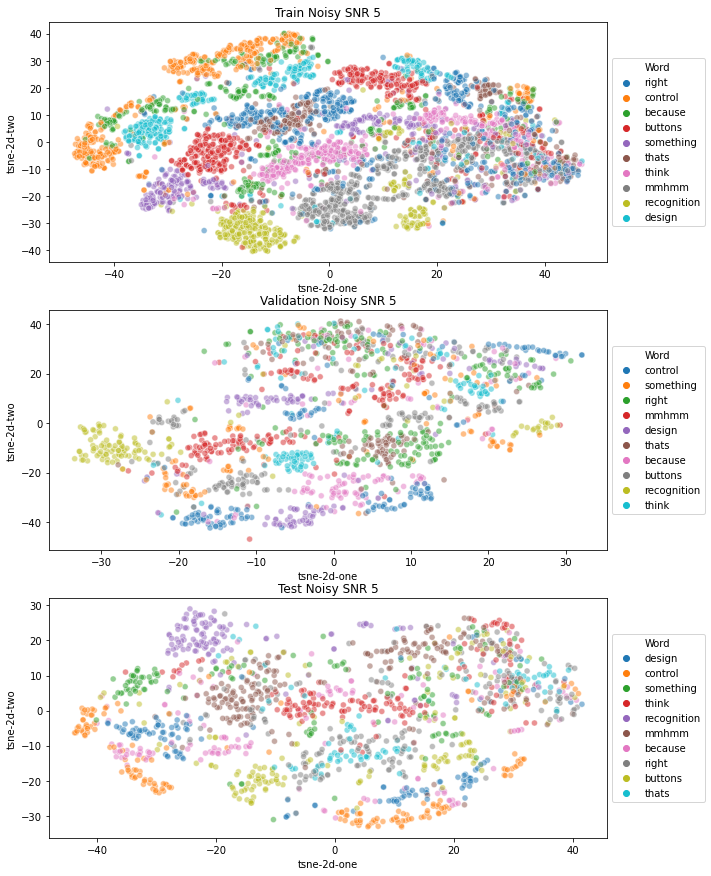

In [32]:
#Visualize the embeddings
visualize_embeddings(snr, train_tsne,val_tsne,test_tsne,train_ds.labels,val_ds.labels,test_ds.labels, train_ds.num_to_word)

## Noisy SNR 0 

In [ ]:
#Load the Noisy Data
snr = 0

#Load the Data
train_ds = CNN_top_k(k = k, split_set = "train", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)
val_ds = CNN_top_k(k = k, split_set = "val", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)
test_ds = CNN_top_k(k = k, split_set = "test", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, cluster = cluster)

In [ ]:
#Load the Models
#num_output
num_output = len(train_ds.c.keys())

#Models
model = load_model(snr = snr, dropout_probability = 0, num_output = num_output)

In [ ]:
#Get the Embeddings
train_em = extract_embeddings(model,train_ds)
val_em = extract_embeddings(model,val_ds)
test_em = extract_embeddings(model,test_ds)

In [ ]:
#Get the tsne
train_tsne = give_tsne(train_em)
val_tsne = give_tsne(val_em)
test_tsne = give_tsne(test_em)

In [ ]:
#Visualize the embeddings
visualize_embeddings(snr, train_tsne,val_tsne,test_tsne,train_ds.labels,val_ds.labels,test_ds.labels, train_ds.num_to_word)

## Noisy SNR -5

In [61]:
#Load the Noisy Data
snr = -5

#Load the Data
train_ds = CNN_dataset(split_set = "train", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, k = k, cluster = cluster)
val_ds = CNN_dataset(split_set = "val", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, k = k, cluster = cluster)
test_ds = CNN_dataset(split_set = "test", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, k = k, cluster = cluster)

Length before filtering on char length 169370
Length after filtering on char length 80813
Finished Loading the Data, 80813 examples
Number of Unique words  8607
Length before filtering on frequency_bounds  (80813,)
Not filtering
Length before filtering for top 10 words 80813
Giving top 10 words
Length after filtering for top 10 words 7496
(4497, 40, 100) (1499, 40, 100) (1500, 40, 100)
Length before filtering on char length 169370
Length after filtering on char length 80813
Finished Loading the Data, 80813 examples
Number of Unique words  8607
Length before filtering on frequency_bounds  (80813,)
Not filtering
Length before filtering for top 10 words 80813
Giving top 10 words
Length after filtering for top 10 words 7496
(4497, 40, 100) (1499, 40, 100) (1500, 40, 100)
Length before filtering on char length 169370
Length after filtering on char length 80813
Finished Loading the Data, 80813 examples
Number of Unique words  8607
Length before filtering on frequency_bounds  (80813,)
Not fil

In [62]:
#Load the Models
#num_output
num_output = len(train_ds.c.keys())

#Models
model = load_model(snr = snr, dropout_probability = 0, num_output = num_output)

In [63]:
#Get the Embeddings
train_em = extract_embeddings(model,train_ds)
val_em = extract_embeddings(model,val_ds)
test_em = extract_embeddings(model,test_ds)

In [64]:
#Get the tsne
train_tsne = give_tsne(train_em)
val_tsne = give_tsne(val_em)
test_tsne = give_tsne(test_em)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4497 samples in 10.165s...
[t-SNE] Computed neighbors for 4497 samples in 54.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4497
[t-SNE] Computed conditional probabilities for sample 2000 / 4497
[t-SNE] Computed conditional probabilities for sample 3000 / 4497
[t-SNE] Computed conditional probabilities for sample 4000 / 4497
[t-SNE] Computed conditional probabilities for sample 4497 / 4497
[t-SNE] Mean sigma: 26.722635
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.198936
[t-SNE] KL divergence after 500 iterations: 1.706428
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1499 samples in 2.488s...
[t-SNE] Computed neighbors for 1499 samples in 6.466s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1499
[t-SNE] Computed conditional probabilities for sample 1499 / 1499
[t-SNE] Mean sigma: 29.398879
[t-SNE] KL divergence after 250 iterations with early exagger

In [70]:
#Visualize the embeddings
visualize_embeddings(snr, train_tsne,val_tsne,test_tsne,train_ds.labels,val_ds.labels,test_ds.labels, train_ds.num_to_word)

<Figure size 936x720 with 0 Axes>

<Figure size 936x720 with 0 Axes>

<Figure size 936x720 with 0 Axes>

# Extra

In [ ]:
#Clean with Dropout

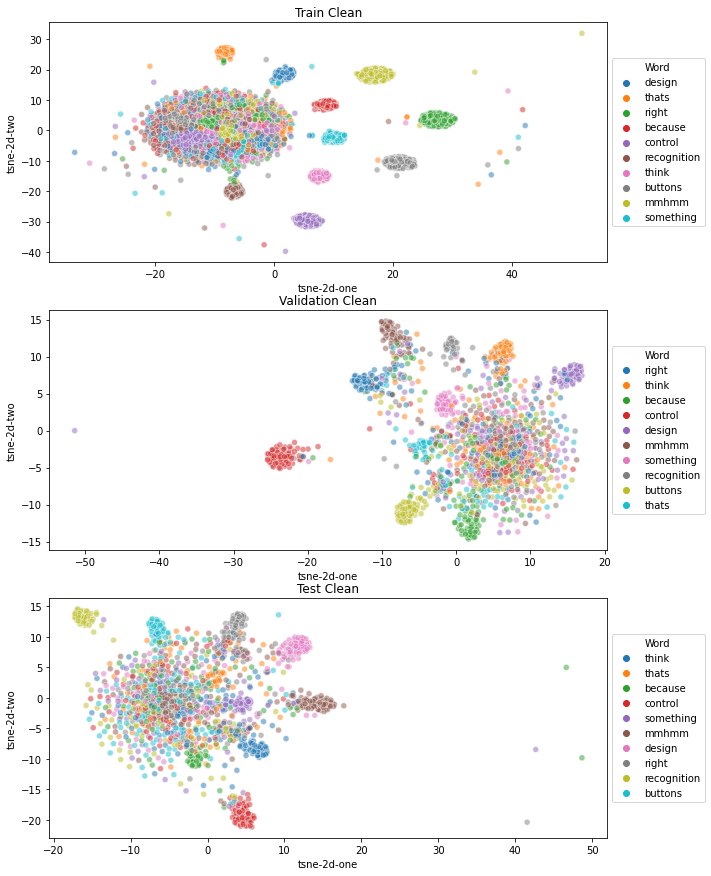

In [14]:
#Visualize the embeddings
visualize_embeddings(snr, train_tsne,val_tsne,test_tsne,train_ds.labels,val_ds.labels,test_ds.labels, train_ds.num_to_word)